# Pneumonia Detection from Chest X-Ray Images 

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.
C:\Users\halis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\halis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\halis\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\halis\anaconda3\envs\te

# Data

In [2]:
# list of files in the data directory
print(os.listdir ("../chest_xray/chest_xray"))
print(os.listdir("../chest_xray/chest_xray/train"))
print(os.listdir("../chest_xray/chest_xray/test"))

['.DS_Store', 'test', 'train', 'val']
['.DS_Store', 'NORMAL', 'PNEUMONIA']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [3]:
# path to the data directory
train_dir = "../chest_xray/chest_xray/train/"
test_dir = "../chest_xray/chest_xray/test/"
val_dir = "../chest_xray/chest_xray/val/"

In [4]:
train_p_dir = train_dir + 'PNEUMONIA'  # directory with our training PNEUMONIA pictures
train_n_dir = train_dir + 'NORMAL'  # directory with our training NORMAL pictures
test_p_dir = test_dir + 'PNEUMONIA'
test_n_dir = test_dir + 'NORMAL'
val_p_dir = val_dir + 'PNEUMONIA'
val_n_dir = val_dir + 'NORMAL'

Let's look at how many pneumonia and normal images are in the training, test and validation directory

In [5]:
num_p_tr = len(os.listdir(train_p_dir))
num_n_tr = len(os.listdir(train_n_dir))

num_p_ts = len(os.listdir(test_p_dir))
num_n_ts = len(os.listdir(test_n_dir))

num_p_val = len(os.listdir(val_p_dir))
num_n_val = len(os.listdir(val_n_dir))

total_train = num_n_tr + num_p_tr
total_test = num_n_ts + num_p_ts
total_val = num_n_val + num_p_val

In [6]:
print('total training pneumonia images:', num_p_tr)
print('total training normal images:', num_n_tr)

print('total testing pneumonia images:', num_p_ts)
print('total testing normal images:', num_n_ts)

print('total validation pneumonia images:', num_p_val)
print('total validation normal images:', num_n_val)
print("--")
print("Total training images:", total_train)
print("Total testing images:", total_test)
print("Total validation images:", total_val)

total training pneumonia images: 3875
total training normal images: 1341
total testing pneumonia images: 390
total testing normal images: 234
total validation pneumonia images: 8
total validation normal images: 9
--
Total training images: 5216
Total testing images: 624
Total validation images: 17


# Show some normal and pneumonia images

In [7]:
Pimages = os.listdir(train_p_dir)
Nimages = os.listdir(train_n_dir)

(Left) - No Pneumonia Vs (Right) - Pneumonia


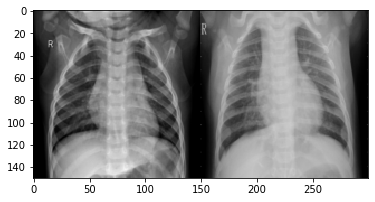

(Left) - No Pneumonia Vs (Right) - Pneumonia


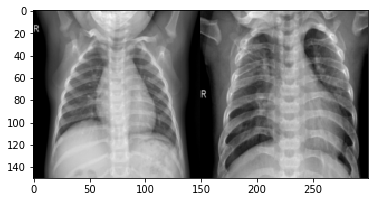

(Left) - No Pneumonia Vs (Right) - Pneumonia


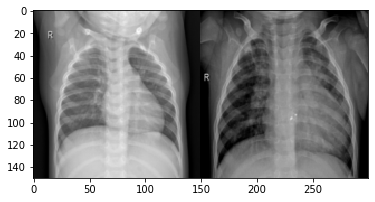

(Left) - No Pneumonia Vs (Right) - Pneumonia


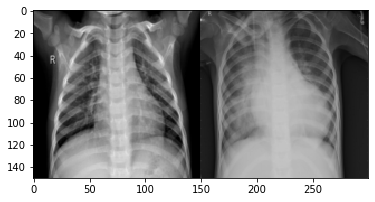

(Left) - No Pneumonia Vs (Right) - Pneumonia


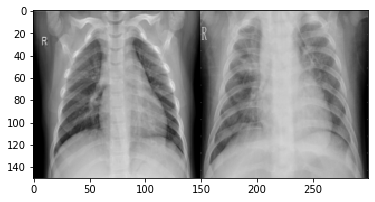

In [8]:
import skimage
from skimage.transform import resize
def plotter(i):
    imagep1 = cv2.imread(train_dir+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    plt.figure(figsize=(6,4))
    plt.imshow(pair)
    plt.show()
for i in range(1,6):
    plotter(i)

In [9]:
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in Nimages:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in Pimages:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,person1567_virus_2722.jpeg,1
1,person1281_virus_2204.jpeg,1
2,person1528_bacteria_3991.jpeg,1
3,person396_bacteria_1796.jpeg,1
4,person53_bacteria_255.jpeg,1


1    3875
0    1341
Name: label, dtype: int64


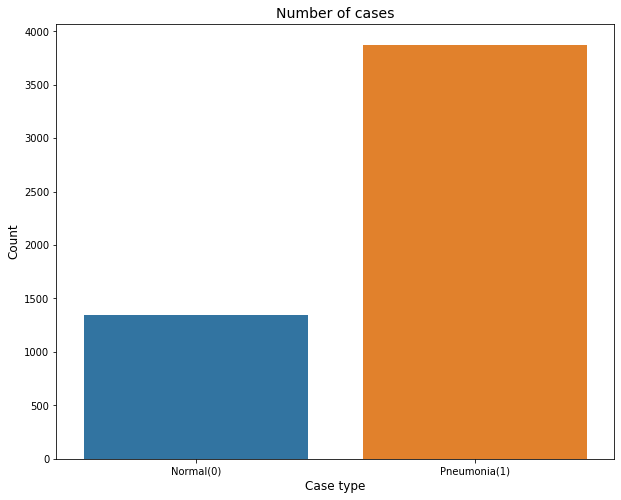

In [10]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# Data Generator 

In [11]:
img_width, img_height = 150, 150
epochs = 20
batch_size = 16

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),classes = ["NORMAL", "PNEUMONIA"],
    batch_size=batch_size,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.


In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),classes = ["NORMAL", "PNEUMONIA"],
    batch_size=batch_size,
    class_mode='categorical')

Found 624 images belonging to 2 classes.


In [16]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,classes = ["NORMAL", "PNEUMONIA"],
    class_mode='categorical')

Found 16 images belonging to 2 classes.


In [17]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# Model

In [18]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
earlystop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

In [20]:
model.compile(loss='binary_crossentropy',
                  optimizer= RMSprop(0.0001),
                  metrics=['accuracy'])

In [21]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 64)       

# Fit Training

In [22]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=total_val // batch_size, callbacks=[earlystop, checkpoint])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
326/326 [==============================] - 417s 1s/step - loss: 0.4916 - accuracy: 0.7761 - val_loss: 0.8809 - val_accuracy: 0.6250
Epoch 2/20
326/326 [==============================] - 403s 1s/step - loss: 0.2948 - accuracy: 0.8779 - val_loss: 0.7921 - val_accuracy: 0.6875
Epoch 3/20
326/326 [==============================] - 408s 1s/step - loss: 0.2362 - accuracy: 0.9083 - val_loss: 1.8559 - val_accuracy: 0.6250
Epoch 4/20
326/326 [==============================] - 406s 1s/step - loss: 0.1923 - accuracy: 0.9289 - val_loss: 0.9515 - val_accuracy: 0.5625
Epoch 5/20
326/326 [==============================] - 396s 1s/step - loss: 0.1823 - accuracy: 0.9335 - val_loss: 1.7262 - val_accuracy: 0.6250
Epoch 6/20
326/326 [==============================] - 397s 1s/step - loss: 0.1648 - accuracy: 0.9384 - val_loss: 2.1245 - val_accuracy: 0.5625
Epoch 7/20
326/326 [==============================] - 2493s 8s/step - loss: 0.1598 - accuracy:

# Plots of Model

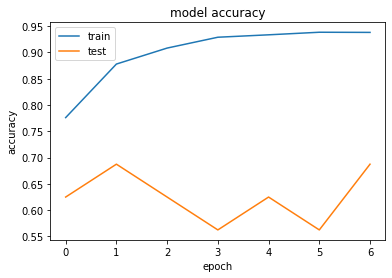

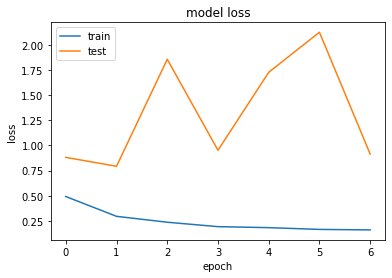

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
from pathlib import Path
from keras.utils import to_categorical 
original_test_label=[]
images=[]

test_normal=Path("../chest_xray/chest_xray/test/NORMAL") 
normal = test_normal.glob('*.jpeg')
for i in normal:
    img = cv2.imread(str(i))
#     print("normal",img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        img = cv2.resize(img, (150,150))
    except Exception as e:
        print(str(e))
    images.append(img)
    label = to_categorical(0, num_classes=2)
    original_test_label.append(label)

test_pneumonia = Path("../chest_xray/chest_xray/test/PNEUMONIA")
pneumonia = test_pneumonia.glob('*.jpeg')
for i in pneumonia:
    img = cv2.imread(str(i))
#     print("pneumonia",img)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    try:
        img = cv2.resize(img, (150,150))
    except Exception as e:
        print(str(e))
    images.append(img)
    label = to_categorical(1, num_classes=2)
    original_test_label.append(label)    

    
images = np.array(images)
original_test_label = np.array(original_test_label)
orig_test_labels = np.argmax(original_test_label, axis=-1)

In [25]:
# Get predictions
pred = model.predict(images)
pred = np.argmax(pred, axis=1) 

<Figure size 432x288 with 0 Axes>

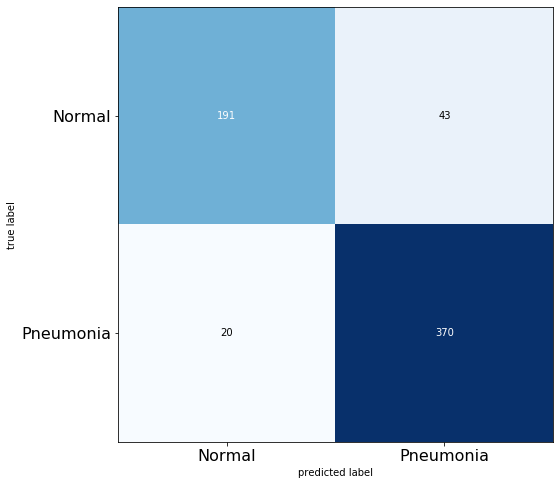

In [26]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_test_labels, pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [27]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.95
Precision of the model is 0.90


In [28]:
from sklearn.metrics import classification_report
# show a nicely formatted classification report
print(classification_report(pred, orig_test_labels, target_names= ['Normal(0)', 'Pneumonia(1)']))

              precision    recall  f1-score   support

   Normal(0)       0.82      0.91      0.86       211
Pneumonia(1)       0.95      0.90      0.92       413

    accuracy                           0.90       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.90      0.90       624

